In [2]:
import numpy as np
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
import geopandas as gp
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd

In [3]:
fl_counties = gp.read_file('c:\\Users\\Andy\\Downloads\\leukemia_fl\\leukemia_fl4.shp')
fl_counties.head()
fl_y = fl_counties['INCIDENCE_'].values.reshape((-1,1)) #leukemia incidence per 100,000
fl_x = fl_counties[['PERCENT_AD', 'PERCENT_OV']].values #Percent adult smokers, percent overweight and obese

coord_x = fl_counties['cen_x']
coord_y = fl_counties['cen_y']
centroid_coords = list(zip(coord_x,coord_y))
#normalize independent variables
fl_x = (fl_x - fl_x.mean(axis=0)) / fl_x.std(axis=0)
fl_y = fl_y.reshape((-1,1))
fl_y = (fl_y- fl_y.mean(axis=0)) / fl_y.std(axis=0)


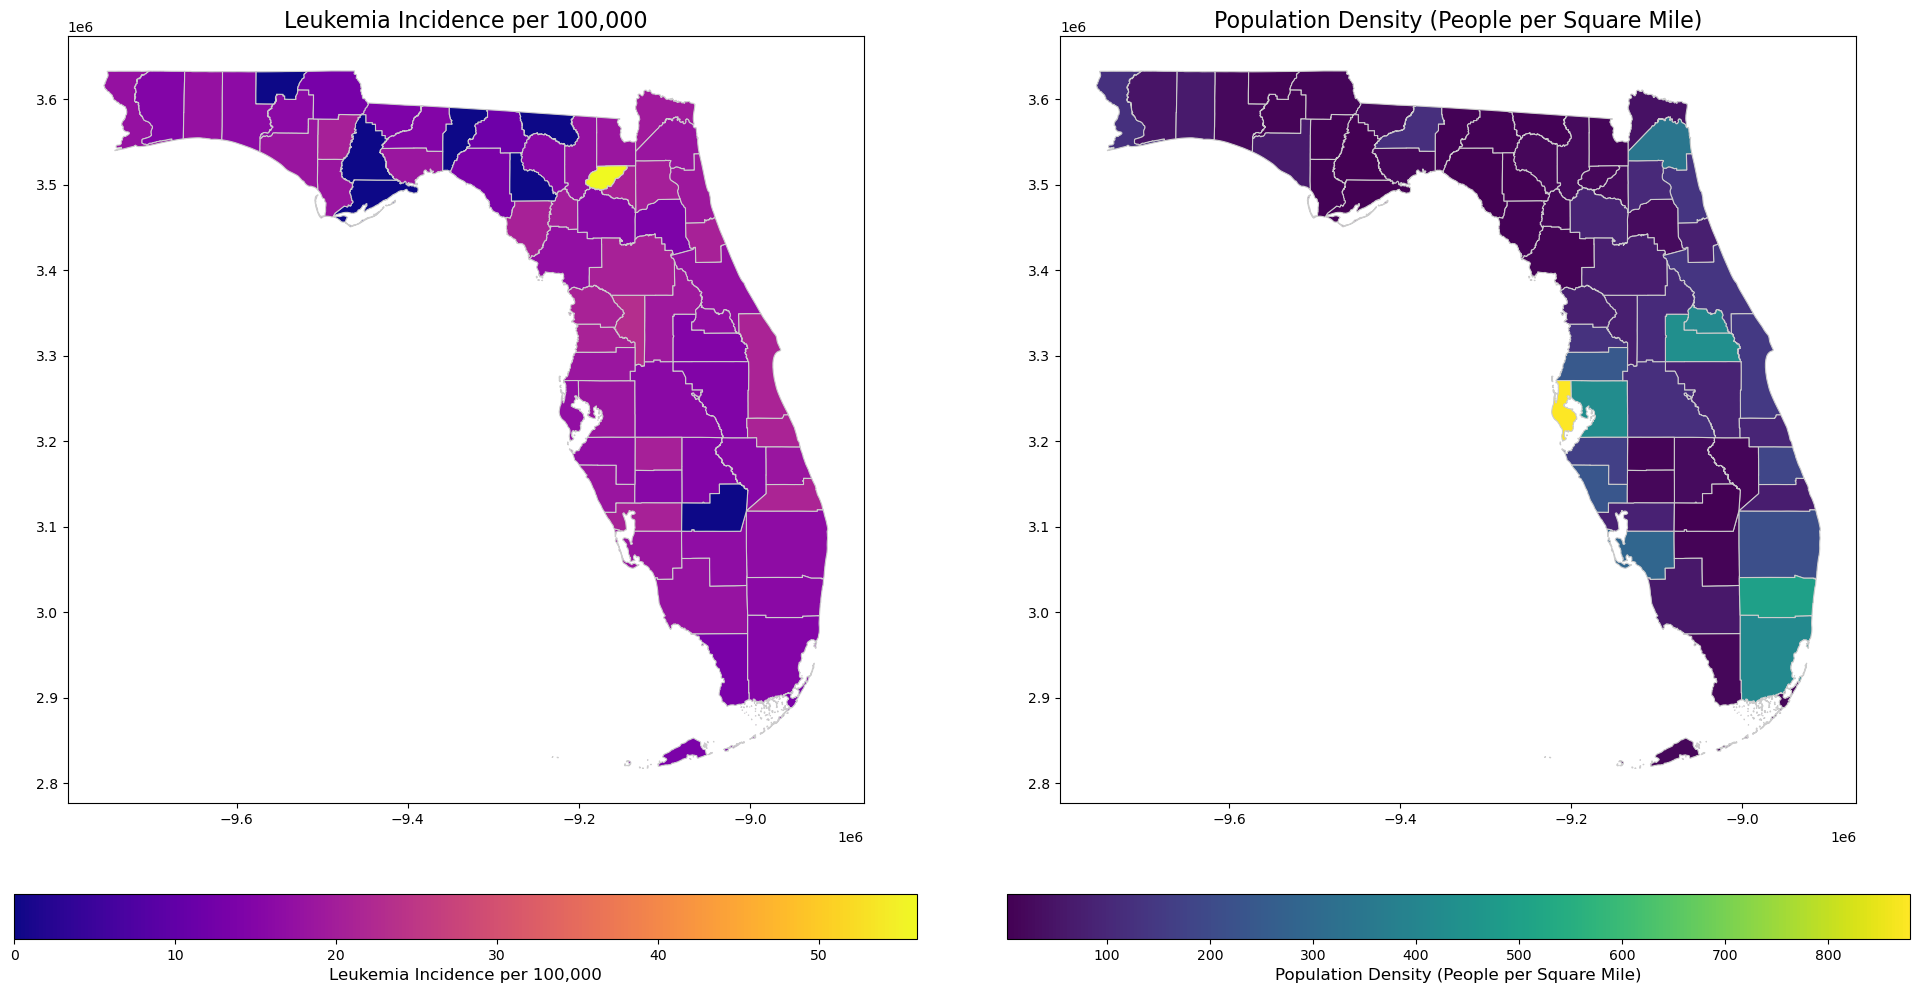

In [27]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

# Plotting leukemia incidence per 100,000 next to population density
ax0 = axes[0]
ax0.set_title('Leukemia Incidence per 100,000', fontsize=16)
cmap_incidence = plt.cm.plasma
vmin_incidence = fl_counties['INCIDENCE_'].min()
vmax_incidence = fl_counties['INCIDENCE_'].max()
fl_counties.plot(column='INCIDENCE_', cmap=cmap_incidence, linewidth=0.8, ax=ax0, edgecolor='0.8', vmin=vmin_incidence, vmax=vmax_incidence)
sm_incidence = plt.cm.ScalarMappable(cmap=cmap_incidence, norm=plt.Normalize(vmin=vmin_incidence, vmax=vmax_incidence))
sm_incidence._A = []
cbar_incidence = fig.colorbar(sm_incidence, ax=ax0, orientation='horizontal', fraction=0.05, pad=0.1)
cbar_incidence.set_label('Leukemia Incidence per 100,000', fontsize=12)

ax1 = axes[1]
ax1.set_title('Population Density (People per Square Mile)', fontsize=16)
cmap_density = plt.cm.viridis
vmin_density = fl_counties['ppl_per_sq'].min()
vmax_density = fl_counties['ppl_per_sq'].max()
fl_counties.plot(column='ppl_per_sq', cmap=cmap_density, linewidth=0.8, ax=ax1, edgecolor='0.8', vmin=vmin_density, vmax=vmax_density)
# population density
sm_density = plt.cm.ScalarMappable(cmap=cmap_density, norm=plt.Normalize(vmin=vmin_density, vmax=vmax_density))
sm_density._A = []
cbar_density = fig.colorbar(sm_density, ax=ax1, orientation='horizontal', fraction=0.05, pad=0.1)
cbar_density.set_label('Population Density (People per Square Mile)', fontsize=12)

plt.tight_layout()
plt.show()

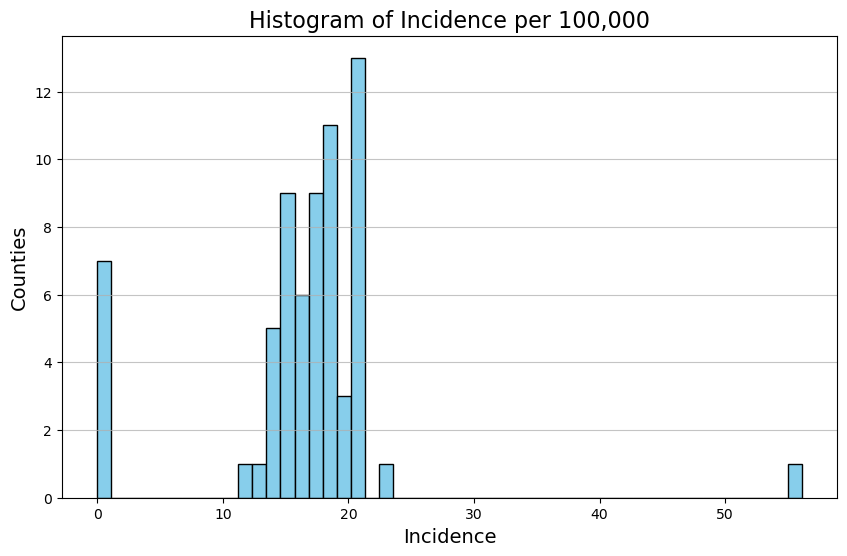

In [25]:
#histogram of dependent variable by county
plt.figure(figsize=(10, 6))
plt.hist(fl_counties['INCIDENCE_'], bins=50, color='skyblue', edgecolor='black')
plt.title('Histogram of Incidence per 100,000', fontsize=16)
plt.xlabel('Incidence', fontsize=14)
plt.ylabel('Counties', fontsize=14)
plt.grid(axis='y', alpha=0.75)
plt.show()
# maybe do a transformation and/or filter out low population density counties next

In [4]:
gwr_selector = Sel_BW(centroid_coords, fl_y, fl_x)
gwr_bw = gwr_selector.search(multi_bw_min=[2])
print(gwr_bw)
gwr_results = GWR(centroid_coords, fl_y, fl_x, gwr_bw).fit()


54.0


In [12]:
np.float = float
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                  67
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             61.821
Log-likelihood:                                                     -92.374
AIC:                                                                190.748
AICc:                                                               193.393
BIC:                                                               -207.279
R2:                                                                   0.077
Adj. R2:                                                              0.048

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [6]:
mgwr_selector = Sel_BW(centroid_coords, fl_y, fl_x, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[1])
print(mgwr_bw)
mgwr_results = MGWR(centroid_coords, fl_y, fl_x, mgwr_selector).fit()

Backfitting:   4%|▎         | 7/200 [00:05<02:21,  1.36it/s]


[45. 61. 65.]


Inference: 100%|██████████| 1/1 [00:00<00:00, 999.12it/s]


In [7]:
np.float = float # fix for MGWR func using deprecated numpy float attribute
mgwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                  67
Number of covariates:                                                     3

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                             61.821
Log-likelihood:                                                     -92.374
AIC:                                                                190.748
AICc:                                                               193.393
BIC:                                                               -207.279
R2:                                                                   0.077
Adj. R2:                                                              0.048

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

In [ ]:
# print("Influence:", gwr_results.influ)

In [48]:
#coefficients
fl_counties['mgwr_intercept'] = mgwr_results.params[:,0]
fl_counties['mgwr_smokers'] = mgwr_results.params[:,1]
fl_counties['mgwr_fat'] = mgwr_results.params[:,2]
fl_counties['residuals'] = gwr_results.std_res
 #code incomplete for mgwr section, could not get standardized residuals based on multi bw
fl_counties['local_r2'] = gwr_results.localR2

mgwr_bw_ci = mgwr_results.get_bws_intervals(mgwr_selector)
#print(mgwr_bw_ci)
mgwr_t = mgwr_results.filter_tvals()
#print(mgwr_t)

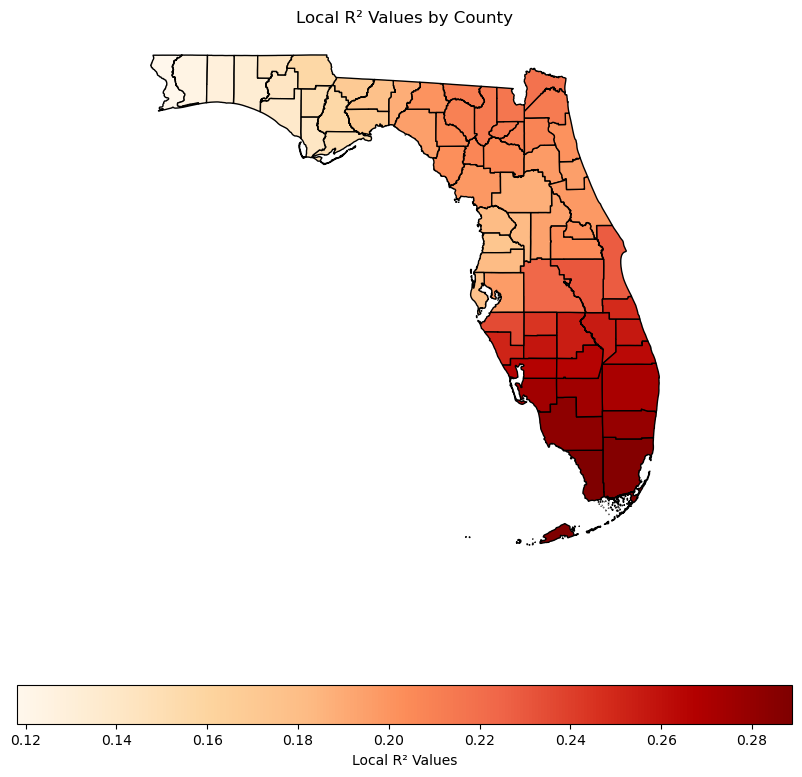

In [49]:
fl_counties['local_r2'] = gwr_results.localR2
fig, ax = plt.subplots(figsize=(10, 10))
fl_counties.plot(column='local_r2', ax=ax, legend=True,
                 cmap='OrRd', edgecolor='black', 
                 legend_kwds={'label': "Local R² Values", 'orientation': "horizontal"})
ax.set_title('Local R² Values by County (GWR)')
ax.set_axis_off()
plt.show()

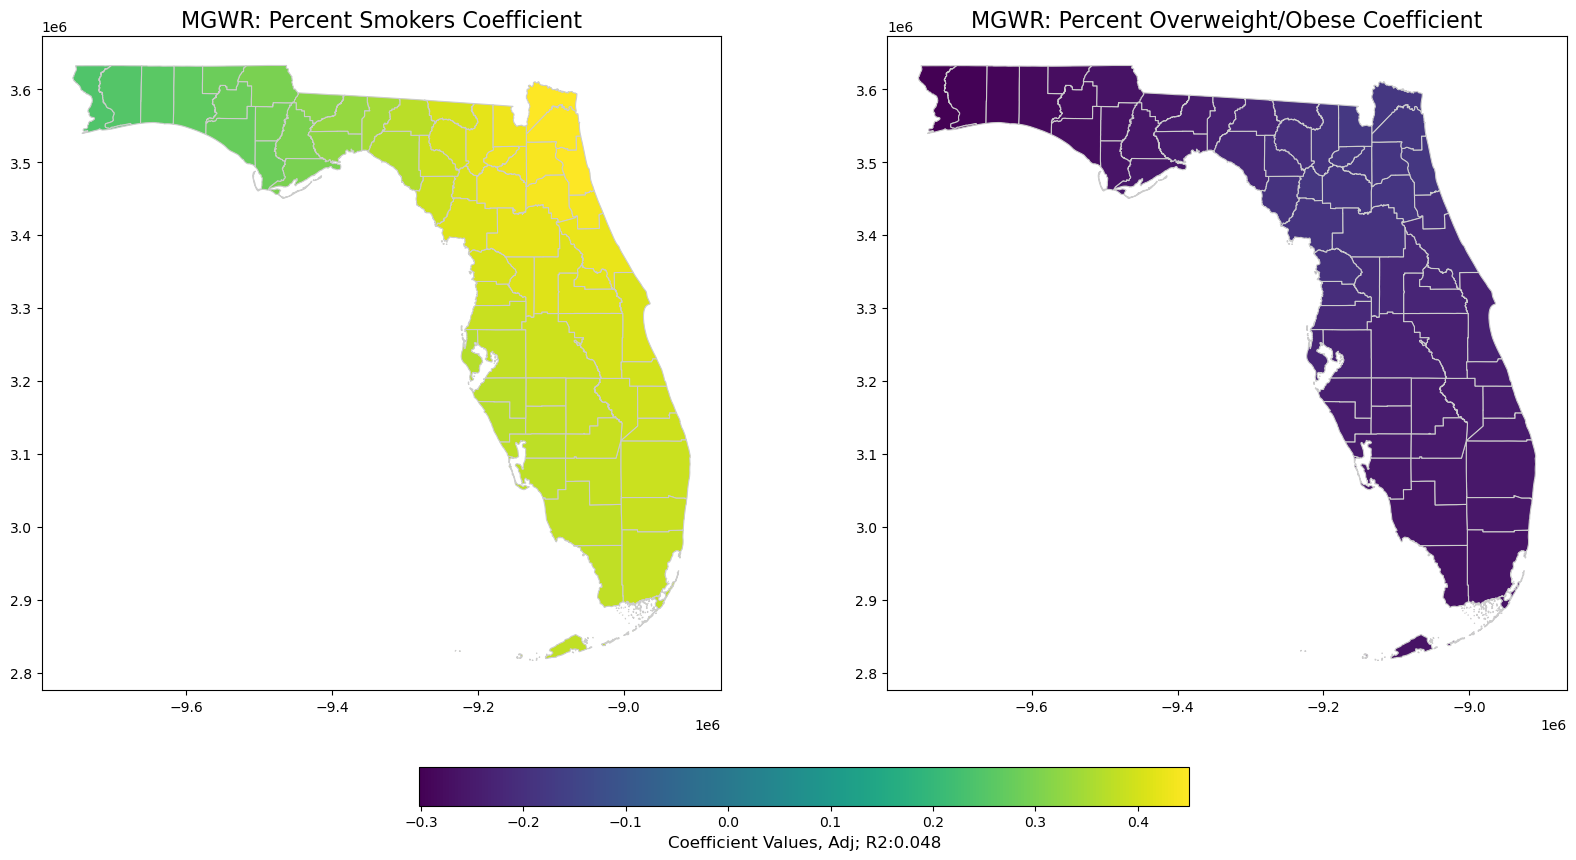

In [40]:

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))
ax0 = axes[0]
ax0.set_title('MGWR: Percent Smokers Coefficient', fontsize=16)
ax1 = axes[1]
ax1.set_title('MGWR: Percent Overweight/Obese Coefficient', fontsize=16)
cmap = plt.cm.viridis
vmin = min(fl_counties['mgwr_smokers'].min(), fl_counties['mgwr_fat'].min())
vmax = max(fl_counties['mgwr_smokers'].max(), fl_counties['mgwr_fat'].max())
fl_counties.plot(column='mgwr_smokers', cmap=cmap, linewidth=0.8, ax=ax0, edgecolor='0.8', vmin=vmin, vmax=vmax)
fl_counties.plot(column='mgwr_fat', cmap=cmap, linewidth=0.8, ax=ax1, edgecolor='0.8', vmin=vmin, vmax=vmax)
sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=axes, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Coefficient Values, Adj; R2:0.048', fontsize=12)

plt.show()


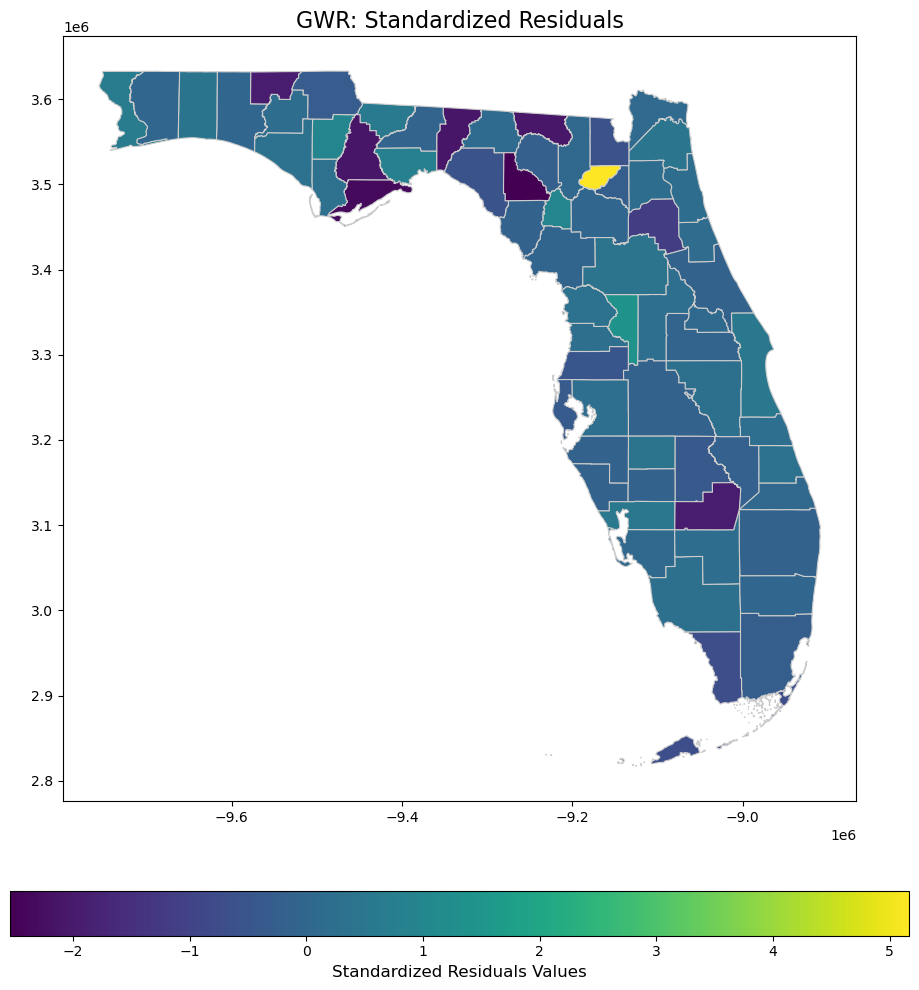

In [21]:
fig, ax = plt.subplots(figsize=(12, 10))
# Plotting the standardized residuals
ax.set_title('GWR: Standardized Residuals', fontsize=16)
cmap = plt.cm.viridis
vmin = fl_counties['residuals'].min()
vmax = fl_counties['residuals'].max()
fl_counties.plot(column='residuals', cmap=cmap, linewidth=0.8, ax=ax, edgecolor='0.8', vmin=vmin, vmax=vmax)

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=vmin, vmax=vmax))
sm._A = []
cbar = fig.colorbar(sm, ax=ax, orientation='horizontal', fraction=0.05, pad=0.1)
cbar.set_label('Standardized Residuals Values', fontsize=12)

plt.tight_layout()
plt.show()
#county with highest residual is also county with highest incidence rate

In [36]:
predicted_z = mgwr_results.predy
original_mean = fl_counties['INCIDENCE_'].mean()  
original_std = fl_counties['INCIDENCE_'].std()    

# Denormalizing the predicted values to graph predicted vs observed, and predicted versus residuals
fl_counties['predicted1'] = (predicted_z * original_std) + original_mean

fl_counties.head()

,NAME,FIPS,INCIDENCE_,AVG_ANNUAL,PERCENT_AD,PERCENT_OV,cen_x,cen_y,COUNTY,POPESTIMAT,area_sq_km,ppl_per_sq,geometry,mgwr_intercept,mgwr_smokers,mgwr_fat,residuals,predicted1
0,Brevard,009,21.1,196,16.3,67.4,-8.987088e+06,3.286203e+06,009,643979,4341.836676,148,"POLYGON ((-9.02e+06 3.33e+06, -9.02e+06 3.33e+...",0.332371,0.407913,-0.232771,0.556391,17.419948
1,Columbia,023,17.7,17,23.9,73.4,-9.197380e+06,3.532487e+06,023,73063,2789.144396,26,"POLYGON ((-9.22e+06 3.5e+06, -9.22e+06 3.5e+06...",-0.036147,0.418972,-0.187484,0.032938,17.738963
2,Gadsden,039,14.1,9,15.1,72.7,-9.419146e+06,3.578267e+06,039,43833,1853.111565,24,"POLYGON ((-9.45e+06 3.58e+06, -9.45e+06 3.58e+...",-0.422273,0.317499,-0.252389,0.607577,9.519055
3,Highlands,055,14.9,30,16.5,65.7,-9.054843e+06,3.166474e+06,055,107614,3645.974628,30,"POLYGON ((-9.08e+06 3.17e+06, -9.08e+06 3.18e+...",0.279703,0.388137,-0.244469,-0.417174,17.826214
4,Jefferson,065,0.0,3 or fewer,17.1,65.0,-9.339170e+06,3.559953e+06,065,15450,2142.135641,7,"POLYGON ((-9.36e+06 3.52e+06, -9.36e+06 3.54e+...",-0.367233,0.348429,-0.232532,-2.109037,13.511884


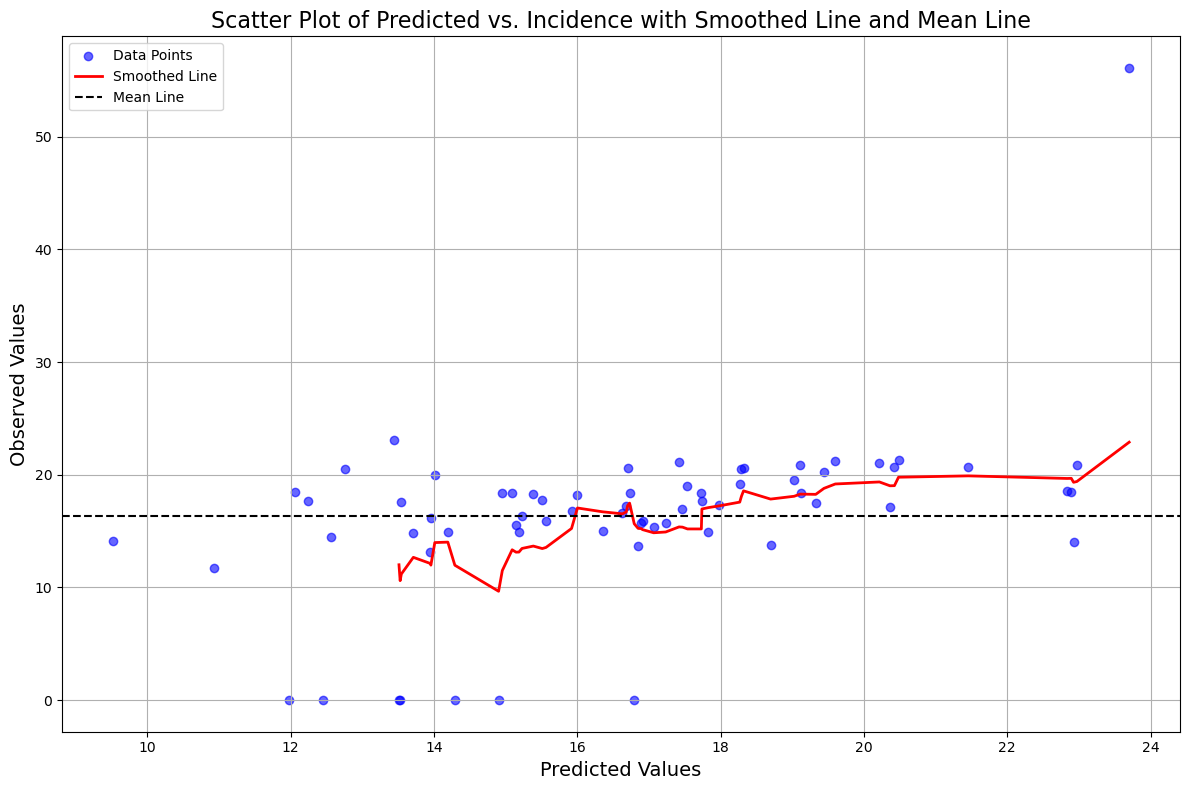

In [46]:

plt.figure(figsize=(12, 8))
plt.scatter(fl_counties['predicted1'], fl_counties['INCIDENCE_'], alpha=0.6, color='blue', label='Data Points')
window_size = 10  #smoother line parameter
fl_counties_sorted = fl_counties.sort_values('predicted1')  
y_smooth = np.convolve(fl_counties_sorted['INCIDENCE_'], np.ones(window_size)/window_size, mode='valid')
x_smooth = fl_counties_sorted['predicted1'][window_size-1:].reset_index(drop=True)  # Align x-values

plt.plot(x_smooth, y_smooth, color='red', label='Smoothed Line', linewidth=2)

mean_incidence = np.mean(fl_counties['INCIDENCE_'])
plt.axhline(mean_incidence, color='black', linestyle='--', label='Mean Line')

plt.title('Scatter Plot of Predicted vs. Observed with Smoothed Line and Mean Line', fontsize=16)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Observed Values', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()


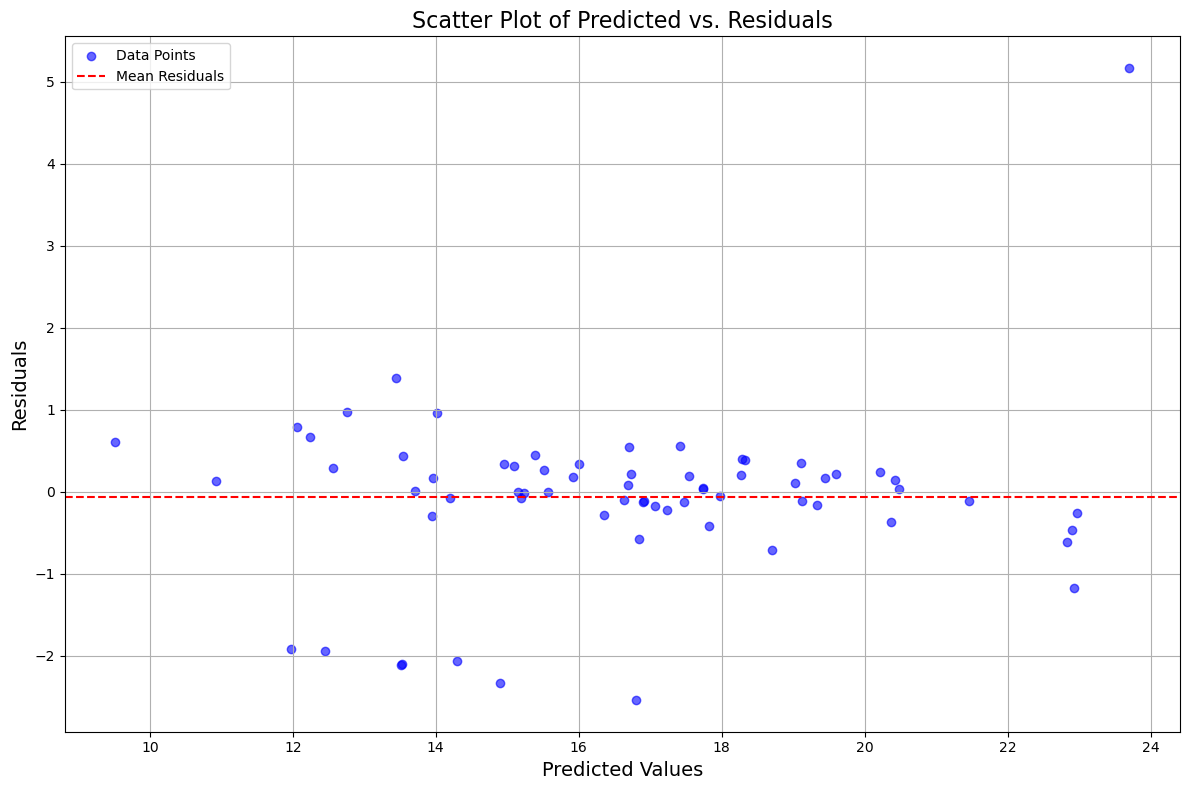

In [47]:
plt.figure(figsize=(12, 8))
plt.scatter(fl_counties['predicted1'], fl_counties['residuals'], alpha=0.6, color='blue', label='Data Points')

mean_residuals = np.mean(fl_counties['residuals'])
plt.axhline(mean_residuals, color='red', linestyle='--', label='Mean Residuals')

plt.title('Scatter Plot of Predicted vs. Residuals', fontsize=16)
plt.xlabel('Predicted Values', fontsize=14)
plt.ylabel('Residuals', fontsize=14)
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

In [ ]:
'''log transformation of dependent variable with percent obesity and percent smoker'''
# fl_logy = np.log(fl_counties['INCIDENCE_'].values.reshape((-1,1)))
# mgwr_sel_log= Sel_BW(centroid_coords, fl_logy, fl_x, multi= true)
# mgwr_bw2 = mgwr_sel_log.search(multi_bw_min=[2])
# print(mgwr_bw2)
# mgwr_results = MGWR(centroid_coords, fl_logy, fl_x, mgwr_sel_log).fit()